In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class missile_interception_3d(gym.Env):
    def __init__(self):
        # 1. Define Action Space (The Joystick: Left/Right, Up/Down)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2, ), dtype=np.float32)
        
        # 2. Define Observation Space (20D ego-frame version)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)

        self.np_random = np.random.RandomState()
        
        # 3. Time Settings
        self.dt_act = 0.1             
        self.n_substeps = 10          
        self.dt_sim = self.dt_act / self.n_substeps 
        self.t_max = 650.0            

        # 4. Physical Limits
        self.a_max = 350.0   # Max G-force (m/s^2) ~35G
        self.da_max = 2500.0 # Jerk Limit (m/s^3)
        self.tau = 0.05      # Airframe Lag
        self.g = 9.81        
        self.collision_radius = 150.0  
        self.max_distance = 4_000_000.0 

        self.p_easy = 1.0                   
        self.range_min = 70_000.0           
        self.range_easy_max = 200_000.0     
        self.range_hard_max = 1_000_000.0   

        self.targetbox_x_min = -15000
        self.targetbox_x_max = 15000
        self.targetbox_y_min = -15000
        self.targetbox_y_max = 15000

    def generate_enemy_missile(self):
        if self.np_random.rand() < self.p_easy:
            self.range_max_used = self.range_easy_max
        else:
            self.range_max_used = self.range_hard_max

        range_min = self.range_min
        self.attack_target_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.attack_target_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)
        self.enemy_launch_angle = self.np_random.uniform(0, 2 * np.pi)
        self.enemy_theta = self.np_random.uniform(0.523599, 1.0472) 

        self.range_max_used = max(self.range_max_used, range_min + 1.0)
        lower_limit = np.sqrt((range_min * self.g) / np.sin(2 * self.enemy_theta))
        upper_limit = np.sqrt((self.range_max_used * self.g) / np.sin(2 * self.enemy_theta))
        self.enemy_initial_velocity = self.np_random.uniform(lower_limit, upper_limit)

        ground_range = (
            self.enemy_initial_velocity * np.cos(self.enemy_theta)
            * (2 * self.enemy_initial_velocity * np.sin(self.enemy_theta) / self.g)
        )

        self.enemy_launch_x = self.attack_target_x + ground_range * np.cos(self.enemy_launch_angle)
        self.enemy_launch_y = self.attack_target_y + ground_range * np.sin(self.enemy_launch_angle)
        self.enemy_z = 0
        self.enemy_x = self.enemy_launch_x
        self.enemy_y = self.enemy_launch_y
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_azimuth = (self.enemy_launch_angle + np.pi) % (2 * np.pi)

    def generate_defense_missile(self):
        self.defense_launch_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.defense_launch_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)

        dx = self.enemy_launch_x - self.defense_launch_x
        dy = self.enemy_launch_y - self.defense_launch_y
        az_nominal = np.arctan2(dy, dx)

        # --- Misalignment (domain randomization of initial heading) ---
        # Mixture: most episodes small error, some episodes large az error
        p_misaligned = 0.35  # 35% "hard" starts
        if self.np_random.rand() < p_misaligned:
            # Hard: big azimuth error → strong RIGHT required
            az_noise = self.np_random.uniform(-np.deg2rad(60.0), np.deg2rad(60.0))
        else:
            # Easy: small azimuth error → gentle correction
            az_noise = self.np_random.uniform(-np.deg2rad(10.0), np.deg2rad(10.0))

        self.defense_azimuth = az_nominal + az_noise

        # Elevation noise: avoid always same vertical plane
        theta_nominal = 0.785398  # ~45 deg
        theta_noise_deg = 10.0
        theta_noise = self.np_random.uniform(
            -np.deg2rad(theta_noise_deg),
            +np.deg2rad(theta_noise_deg),
        )
        self.defense_theta = float(np.clip(theta_nominal + theta_noise,
                                           np.deg2rad(10.0),
                                           np.deg2rad(80.0)))
        # ---------------------------------------------------------------

        base_velocity = 3000.0
        if hasattr(self, 'range_max_used'):
            velocity_scale = min(self.range_max_used / self.range_easy_max, 1.5)
            self.defense_initial_velocity = base_velocity * velocity_scale
        else:
            self.defense_initial_velocity = base_velocity

        self.defense_x = self.defense_launch_x
        self.defense_y = self.defense_launch_y
        self.defense_z = 0.0
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)

        self.defense_ax = 0.0
        self.defense_ay = 0.0
        self.defense_az = 0.0
    
    def _smoothstep(self, x: float) -> float:
        """Smooth ramp 0->1 with zero slope at ends, clamps outside [0,1]"""
        x = float(np.clip(x, 0.0, 1.0))
        return x * x * (3.0 - 2.0 * x)
    
    def calculate_pronav(self):
        eps = 1e-9

        # Relative geometry (use float64 for stability)
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        v = self.defense_vel.astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        V = float(np.linalg.norm(v)) + eps

        rhat = r / R
        vhat = v / V

        # Heading error alpha = angle between velocity direction and LOS direction
        cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
        alpha = float(np.arccos(cosang))  # radians

        # LOS angular rate omega (world frame)
        omega = np.cross(r, vrel) / (float(np.dot(r, r)) + eps)
        omega_mag = float(np.linalg.norm(omega))

        # Closing speed (positive => closing)
        vc = -float(np.dot(r, vrel)) / R

        # --- PN term ---
        N = 3.0
        a_pn = N * vc * np.cross(omega, rhat)  # lateral accel in world frame

        # --- Acquisition term (turn-to-LOS) ---
        # Perpendicular component of LOS relative to forward direction
        rhat_perp = rhat - float(np.dot(rhat, vhat)) * vhat
        nperp = float(np.linalg.norm(rhat_perp))

        if nperp < 1e-8:
            a_acq = np.zeros(3, dtype=np.float64)
        else:
            rhat_perp /= nperp  # unit sideways "turn toward LOS" direction

            # Curvature-based magnitude: ~k * V^2 / R, saturate later via a_max
            k_acq = 5.0  # try 3.0–8.0
            a_acq = k_acq * (V * V / R) * rhat_perp

        # --- Blend weight w: 0 => pure PN, 1 => pure acquisition ---

        # Alpha-based weight (dominant)
        alpha_on   = np.deg2rad(20.0)   # start blending earlier
        alpha_full = np.deg2rad(55.0)

        x_alpha = (alpha - alpha_on) / (alpha_full - alpha_on + eps)
        w_alpha = self._smoothstep(x_alpha)

        # Omega-based modifier (only boosts acquisition when PN is sleepy)
        omega_full = 0.00
        omega_on   = 0.05   # <-- key: less brittle than 0.02

        x_omega = (omega_on - omega_mag) / (omega_on - omega_full + eps)
        w_omega = self._smoothstep(x_omega)

        # Robust combine: alpha dominates; omega can't fully shut it off
        w = w_alpha * (0.25 + 0.75 * w_omega)

        # Optional: if not closing, force strong acquisition
        if vc <= 0.0:
            w = max(w, 0.9)

        a_ideal = (1.0 - w) * a_pn + w * a_acq

        # Project into your lateral control basis (right/up) and normalize by a_max
        # Note: Environment now handles gravity compensation internally,
        # so ProNav outputs desired NET lateral accel (same semantics as PPO)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)
        a_right = float(np.dot(a_ideal, right))
        a_up    = float(np.dot(a_ideal, up))

        action = np.array([a_right / self.a_max, a_up / self.a_max], dtype=np.float32)
        return np.clip(action, -1.0, 1.0)
    
    def _rate_limit_norm(self, a_cmd, a_prev, da_max, dt):
        delta = a_cmd - a_prev
        max_delta = da_max * dt
        dnorm = float(np.linalg.norm(delta))
        if dnorm <= max_delta or dnorm < 1e-9:
            return a_cmd
        return a_prev + delta * (max_delta / dnorm)
    
    def _segment_sphere_intersect(self, r0, r1, r_hit):
        dr = r1 - r0
        dr_norm_sq = float(np.dot(dr, dr))
        if dr_norm_sq < 1e-12:
            return float(np.dot(r0, r0)) <= r_hit * r_hit
        s_star = -float(np.dot(r0, dr)) / dr_norm_sq
        s_star = max(0.0, min(1.0, s_star))
        r_closest = r0 + s_star * dr
        return float(np.dot(r_closest, r_closest)) <= r_hit * r_hit
    
    def _get_obs(self):
        eps = 1e-9

        # World-frame relative state
        r_world = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel_world = (self.enemy_vel - self.defense_vel).astype(np.float64)

        # Local basis from defense velocity (world frame unit vectors)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)

        # ===============================
        # 1) Ego-frame (body-frame) r and vrel
        # ===============================
        r_body = np.array([
            float(np.dot(r_world, forward)),
            float(np.dot(r_world, right)),
            float(np.dot(r_world, up)),
        ], dtype=np.float64)

        vrel_body = np.array([
            float(np.dot(vrel_world, forward)),
            float(np.dot(vrel_world, right)),
            float(np.dot(vrel_world, up)),
        ], dtype=np.float64)

        # Normalize r_body / vrel_body (keep your original scaling)
        pos_scale = float(self.range_hard_max)   # 1_000_000
        vel_scale = 4000.0

        r_body_n = (r_body / (pos_scale + eps)).astype(np.float32)
        vrel_body_n = (vrel_body / (vel_scale + eps)).astype(np.float32)

        # ===============================
        # 2) Actuator state in the same action frame
        # ===============================
        a_lat = np.array([
            float(np.dot(self.a_actual, right)) / (self.a_max + eps),
            float(np.dot(self.a_actual, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # NEW: hidden actuator state that affects transitions
        a_cmd_prev_lat = np.array([
            float(np.dot(self.a_cmd_prev, right)) / (self.a_max + eps),
            float(np.dot(self.a_cmd_prev, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # ===============================
        # 3) Scalar helpers (kept)
        # ===============================
        dist = float(np.linalg.norm(r_world)) + 1e-6
        v_close = -float(np.dot(r_world, vrel_world)) / dist  # positive when closing

        dist_n = np.float32(np.clip(dist / 1_000_000.0, 0.0, 4.0))
        vclose_n = np.float32(np.clip(v_close / 3000.0, -2.0, 2.0))
        dist_vclose_feat = np.array([dist_n, vclose_n], dtype=np.float32)

        # Defense own vertical state (keep for ground constraint)
        def_z_n = np.float32(np.clip(self.defense_pos[2] / 100_000.0, -1.0, 2.0))
        def_vz_n = np.float32(np.clip(self.defense_vel[2] / 3000.0, -2.0, 2.0))
        def_state_feat = np.array([def_z_n, def_vz_n], dtype=np.float32)

        # ===============================
        # 4) Keep your geometry features (consistent with ego-frame)
        # ===============================
        dist_body = float(np.linalg.norm(r_body)) + 1e-6

        # LOS lateral projections in body frame
        los_right = float(r_body[1] / dist_body)
        los_up    = float(r_body[2] / dist_body)

        # LOS rate omega in body frame: omega = (r x vrel)/||r||^2
        dist2_body = float(np.dot(r_body, r_body)) + eps
        omega_body = np.cross(r_body, vrel_body) / dist2_body

        omega_right = float(omega_body[1])
        omega_up    = float(omega_body[2])

        omega_scale = 2.0
        omega_right_n = float(np.clip(omega_right / omega_scale, -2.0, 2.0))
        omega_up_n    = float(np.clip(omega_up / omega_scale, -2.0, 2.0))

        geom_feat = np.array([los_right, los_up, omega_right_n, omega_up_n], dtype=np.float32)

        # ===============================
        # 5) NEW: kinematics garnish
        # ===============================
        V_def = float(np.linalg.norm(self.defense_vel))
        V_def_n = np.float32(np.clip(V_def / 3000.0, 0.0, 3.0))  # scale: 3000 m/s baseline
        forward_z = np.float32(float(forward[2]))               # dot(forward, world_up) since world_up=[0,0,1]

        kin_feat = np.array([V_def_n, forward_z], dtype=np.float32)

        # Final obs (20D)
        obs = np.concatenate(
            [r_body_n, vrel_body_n, a_lat, a_cmd_prev_lat, dist_vclose_feat, def_state_feat, geom_feat, kin_feat],
            axis=0
        ).astype(np.float32)

        # Optional sanity check while iterating
        # assert obs.shape == (20,), obs.shape

        return obs

    def _compute_lateral_basis(self, velocity):
        """
        Horizon-stable basis:
          forward = along velocity
          right   = world_up x forward  (horizontal right)
          up      = forward x right     (completes orthonormal frame)
        This keeps 'up' as close to world-up as possible and avoids weird twisting.
        """
        speed = float(np.linalg.norm(velocity))
        if speed < 1.0:
            forward = np.array([1.0, 0.0, 0.0], dtype=np.float32)
        else:
            forward = (velocity / speed).astype(np.float32)

        world_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)

        # right = world_up x forward
        right_raw = np.cross(world_up, forward)
        rnorm = float(np.linalg.norm(right_raw))

        # If forward is near world_up, right_raw ~ 0. Pick a consistent fallback.
        if rnorm < 1e-6:
            # Choose a fixed "north" axis in world XY and build right from that
            # This prevents random spinning when vertical.
            north = np.array([1.0, 0.0, 0.0], dtype=np.float32)
            right_raw = np.cross(north, forward)
            rnorm = float(np.linalg.norm(right_raw))
            if rnorm < 1e-6:
                north = np.array([0.0, 1.0, 0.0], dtype=np.float32)
                right_raw = np.cross(north, forward)
                rnorm = float(np.linalg.norm(right_raw))

        right = (right_raw / (rnorm + 1e-9)).astype(np.float32)

        # up = forward x right (not right x forward)
        up_raw = np.cross(forward, right)
        up = (up_raw / (float(np.linalg.norm(up_raw)) + 1e-9)).astype(np.float32)

        return forward, right, up

    def step(self, action):
        if getattr(self, "done", False):
            return self._get_obs(), 0.0, True, False, {"event": "called_step_after_done", "dist": self.relative_distances[-1]}
        
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        mag = float(np.linalg.norm(action))
        if mag > 1.0:
            action = action / mag
            mag = 1.0
        
        # Update episode trackers
        self.ep_max_action_mag = max(self.ep_max_action_mag, float(mag))
        self.ep_max_accel = max(self.ep_max_accel, float(np.linalg.norm(self.a_actual)))

        dist_before = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        terminated = False
        truncated = False
        event = "running"
        
        for _ in range(self.n_substeps):
            dt = self.dt_sim
            enemy_pos_old = self.enemy_pos.copy()
            defense_pos_old = self.defense_pos.copy()
            
            forward, right, up = self._compute_lateral_basis(self.defense_vel)
            
            # Agent command = desired NET lateral accel (world frame)
            a_net_lat_cmd = (action[0] * self.a_max * right) + (action[1] * self.a_max * up)
            
            # Gravity (world frame)
            g_vec = np.array([0.0, 0.0, -self.g], dtype=np.float32)
            
            # Lateral component of gravity in the right/up plane
            g_lat = (np.dot(g_vec, right) * right) + (np.dot(g_vec, up) * up)
            
            # Fins must cancel lateral gravity to achieve commanded NET lateral accel
            a_fins_cmd = a_net_lat_cmd - g_lat
            
            # Apply rate limit + lag to fins acceleration
            self.a_cmd_prev = self._rate_limit_norm(a_fins_cmd, self.a_cmd_prev, self.da_max, dt)
            self.a_actual += (self.a_cmd_prev - self.a_actual) * (dt / self.tau)
            
            # Integrate translational dynamics
            self.defense_vel += (self.a_actual + g_vec) * dt
            self.defense_pos += self.defense_vel * dt
            self.defense_x, self.defense_y, self.defense_z = self.defense_pos
            
            # Enemy missile: pure ballistic (gravity only)
            self.enemy_vel += g_vec * dt
            self.enemy_pos += self.enemy_vel * dt
            self.enemy_x, self.enemy_y, self.enemy_z = self.enemy_pos
            self.t += dt
            
            r0 = enemy_pos_old - defense_pos_old
            r1 = self.enemy_pos - self.defense_pos
            if self._segment_sphere_intersect(r0, r1, self.collision_radius):
                self.success = True
                terminated = True
                self.done = True
                event = "hit"
                self.time_to_hit = float(self.t)
                self.terminal_event = "hit"
                break
            
            dist = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
            if dist > self.max_distance:
                truncated = True
                self.done = True
                event = "diverged"
                self.terminal_event = "diverged"
                break
            if self.defense_pos[2] < 0:
                terminated = True
                self.done = True
                event = "defense_ground"
                self.terminal_event = "defense_ground"
                break
            if self.enemy_pos[2] < 0:
                terminated = True
                self.done = True
                event = "enemy_ground"
                self.terminal_event = "enemy_ground"
                break
            if self.t >= self.t_max:
                truncated = True
                self.done = True
                event = "timeout"
                self.terminal_event = "timeout"
                break

        self.enemy_path.append(self.enemy_pos.copy())
        self.defense_path.append(self.defense_pos.copy())
        self.relative_distances.append(float(np.linalg.norm(self.enemy_pos - self.defense_pos)))
        self.times.append(self.t)
        
        obs = self._get_obs()
        dist_after = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        self.min_dist = min(getattr(self, "min_dist", float("inf")), dist_after)
        self.ep_min_dist = min(self.ep_min_dist, float(dist_after))
        
        # Reward calculation (same as before)
        r_progress = (dist_before - dist_after) / 100.0
        v_scale = 1500.0
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)
        d = float(np.linalg.norm(r)) + 1e-9
        rhat = r / d
        d_dot = float(np.dot(rhat, vrel))
        r_close = np.tanh((-d_dot) / v_scale)
        
        # Accumulate shaping rewards for debugging
        self.sum_r_progress += float(r_progress)
        self.sum_r_close += float(r_close)
        
        # Reward breakdown (named components)
        step_penalty = -0.001
        terminal_bonus = 0.0
        terminal_penalty = 0.0
        
        if self.success:
            terminal_bonus = 10000.0
        elif terminated or truncated:
            if event == "defense_ground":
                terminal_penalty += 5000.0
            terminal_penalty += min(2000.0, self.ep_min_dist / 50.0)
        
        reward = (1.0 * r_progress) + (0.1 * r_close) + step_penalty + terminal_bonus - terminal_penalty
        
        info = {
            "event": event,
            "t": float(self.t),
            
            # reward pieces (training-related)
            "reward_terms": {
                "r_progress": float(r_progress),
                "r_close": float(r_close),
                "step_penalty": float(step_penalty),
                "terminal_bonus": float(terminal_bonus),
                "terminal_penalty": float(-terminal_penalty),  # negative contribution
            },
            "reward": float(reward),
            
            # eval snapshots (NOT the full episode metrics yet)
            "eval_step": {
                "dist": float(dist_after),
                "action_mag": float(mag),
                "accel_norm": float(np.linalg.norm(self.a_actual)),
            },
        }
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None: self.np_random = np.random.RandomState(seed)
        self.done = False
        self.success = False
        self.t = 0.0
        self.generate_enemy_missile()
        self.generate_defense_missile()
        
        self.defense_vel = np.array([
            self.defense_initial_velocity * np.cos(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_theta)
        ], dtype=np.float32)
        
        self.enemy_vel = np.array([
            self.enemy_initial_velocity * np.cos(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_theta)
        ], dtype=np.float32)
        
        self.a_actual = np.zeros(3, dtype=np.float32)
        self.a_cmd_prev = np.zeros(3, dtype=np.float32)
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_path = [self.enemy_pos.copy()]
        self.defense_path = [self.defense_pos.copy()]
        self.relative_distances = [float(np.linalg.norm(self.enemy_pos - self.defense_pos))]
        self.times = [self.t]
        self.min_dist = float(self.relative_distances[-1])
        self.sum_r_progress = 0.0
        self.sum_r_close = 0.0
        
        # --- episode eval trackers (NOT used in reward) ---
        self.ep_min_dist = float("inf")
        self.ep_max_action_mag = 0.0
        self.ep_max_accel = 0.0          # optional: actual accel norm
        self.time_to_hit = None
        self.terminal_event = "running"
        
        return self._get_obs(), {}


# ==========================================
# EVALUATION FUNCTION (separate from training reward)
# ==========================================
def evaluate_policy(env, policy_fn, n_episodes=100, seed0=0):
    """
    Evaluate a policy and return episode-level metrics.
    This is separate from training reward - these metrics are what you actually care about.
    
    Args:
        env: missile_interception_3d environment instance
        policy_fn: Function that takes obs and returns action
        n_episodes: Number of episodes to evaluate
        seed0: Starting seed (episodes use seed0, seed0+1, ..., seed0+n_episodes-1)
    
    Returns:
        summary: Dict with aggregated metrics (hit_rate, min_dist stats, etc.)
        metrics: Dict with raw episode data
    """
    metrics = {
        "hits": 0,
        "ground_defense": 0,
        "ground_enemy": 0,
        "diverged": 0,
        "timeout": 0,
        "min_dist_list": [],
        "time_to_hit_list": [],
        "max_g_list": [],
    }

    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + i)
        done = False

        while not done:
            action = policy_fn(obs)  # your PPO policy OR env.calculate_pronav() baseline
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        event = info["event"]
        metrics["min_dist_list"].append(env.ep_min_dist)
        metrics["max_g_list"].append(env.ep_max_action_mag)

        if event == "hit":
            metrics["hits"] += 1
            if env.time_to_hit is not None:
                metrics["time_to_hit_list"].append(env.time_to_hit)
        elif event == "defense_ground":
            metrics["ground_defense"] += 1
        elif event == "enemy_ground":
            metrics["ground_enemy"] += 1
        elif event == "diverged":
            metrics["diverged"] += 1
        elif event == "timeout":
            metrics["timeout"] += 1

    hit_rate = metrics["hits"] / n_episodes

    summary = {
        "hit_rate": hit_rate,
        "min_dist_mean": float(np.mean(metrics["min_dist_list"])),
        "min_dist_p50": float(np.median(metrics["min_dist_list"])),
        "min_dist_p10": float(np.percentile(metrics["min_dist_list"], 10)),
        "time_to_hit_mean": float(np.mean(metrics["time_to_hit_list"])) if metrics["time_to_hit_list"] else None,
        "max_g_mean": float(np.mean(metrics["max_g_list"])),
        "violations": {
            "defense_ground": metrics["ground_defense"],
            "enemy_ground": metrics["ground_enemy"],
            "diverged": metrics["diverged"],
            "timeout": metrics["timeout"],
        }
    }
    return summary, metrics


# ==========================================
# TEST PRONAV BASELINE (No Animation)
# ==========================================

# def run_baseline():
#     env = missile_interception_3d()
#     outcomes = []
#     min_distances = []
#     action_loads = [] # Track if we are saturating (maxing out fins)

#     N_EPISODES = 50
#     print(f"Running {N_EPISODES} episodes of Augmented ProNav...")

#     for i in range(N_EPISODES):
#         obs, _ = env.reset(seed=i)
#         done = False
#         ep_actions = []

#         while not done:
#             # 1. Ask ProNav for the move
#             action = env.calculate_pronav()
            
#             # 2. Track how hard it's pushing (0.0 to 1.0)
#             mag = np.linalg.norm(action)
#             ep_actions.append(mag)

#             obs, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated
        
#         outcomes.append(info['event'])
#         min_distances.append(info['min_dist'])
#         avg_load = np.mean(ep_actions)
#         action_loads.append(avg_load)

#         print(f"Ep {i+1:02d} | Res: {info['event']:<14} | Min Dist: {info['min_dist']:.1f} m | Avg G-Load: {avg_load*100:.1f}%")

#     # Final Stats
#     hits = outcomes.count("hit")
#     print("\n--- SUMMARY ---")
#     print(f"Hit Rate: {hits}/{N_EPISODES} ({hits/N_EPISODES*100:.1f}%)")
#     print(f"Average Miss Distance (Non-hits): {np.mean([d for d, e in zip(min_distances, outcomes) if e != 'hit']):.2f} m")
#     print(f"Average G-Loading: {np.mean(action_loads)*100:.1f}% (If >90%, missile is physically too weak)")

# if __name__ == "__main__":
#     run_baseline()

In [6]:
# def collect_pronav_actions(env_class, n_episodes=200, seed0=0):
#     rights = []
#     ups = []
#     events = Counter()

#     for ep in range(n_episodes):
#         env = env_class()
#         obs, _ = env.reset(seed=seed0 + ep)
#         done = False
#         while not done:
#             a = env.calculate_pronav()
#             rights.append(float(a[0]))
#             ups.append(float(a[1]))
#             obs, r, terminated, truncated, info = env.step(a)
#             done = terminated or truncated
#         events[info.get("event", "unknown")] += 1

#     rights = np.array(rights)
#     ups = np.array(ups)

#     print("Events:", events)
#     print("RIGHT: mean/std/min/max:", rights.mean(), rights.std(), rights.min(), rights.max())
#     print("UP:    mean/std/min/max:", ups.mean(), ups.std(), ups.min(), ups.max())

#     for thr in [0.01, 0.02, 0.05, 0.1]:
#         print(f"|RIGHT| > {thr:0.02f}: {(np.abs(rights) > thr).mean()*100:0.2f}%")

#     return rights, ups

# rights, ups = collect_pronav_actions(missile_interception_3d, n_episodes=300, seed0=0)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import Counter
from IPython.display import HTML, display

# ==========================================
# FIXED-SEED EVALUATION HARNESS
# ==========================================
EVAL_SEEDS = list(range(200))  # Fixed list of 200 seeds for consistent evaluation

def evaluate_policy(env_class, policy_fn, seeds=EVAL_SEEDS, verbose=False):
    """
    Evaluate a policy on fixed seeds for consistent comparison.
    
    Args:
        env_class: The environment class (e.g., missile_interception_3d)
        policy_fn: Function that takes (env, obs) and returns action
        seeds: List of seeds to evaluate on (default: EVAL_SEEDS)
        verbose: If True, print per-episode details
    
    Returns:
        hit_rate: Fraction of episodes that resulted in "hit"
        med_min_dist: Median minimum distance across all episodes
        counts: Counter of event types
    """
    events = []
    min_dists = []
    
    for s in seeds:
        env = env_class()
        obs, _ = env.reset(seed=s)
        done = False
        
        while not done:
            action = policy_fn(env, obs)
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        event = info.get("event", "unknown")
        min_dist = info.get("min_dist", float("inf"))
        
        events.append(event)
        min_dists.append(min_dist)
        
        if verbose and (s < 5 or event != "hit"):  # Print first 5 or failures
            print(f"  Seed {s:3d}: {event:15s} | min_dist={min_dist:.1f}m")
    
    hit_rate = sum(e == "hit" for e in events) / len(events)
    med_min_dist = float(np.median(min_dists))
    counts = Counter(events)
    
    return hit_rate, med_min_dist, counts

# ==========================================
# ANIMATION FUNCTIONS (copy from training script)
# ==========================================
def update_paths(num, xe, ye, ze, xd, yd, zd, lines, ax):
    lines[0].set_data_3d(xe[:num], ye[:num], ze[:num])
    lines[1].set_data_3d(xd[:num], yd[:num], zd[:num])
    ax.view_init(elev=20, azim=-60 + (num * 0.2))
    return lines

def animate_trajectories(enemy_path, defense_path):
    enemy_path_array = np.array(enemy_path)
    defense_path_array = np.array(defense_path)

    xe, ye, ze = enemy_path_array[:, 0], enemy_path_array[:, 1], enemy_path_array[:, 2]
    xd, yd, zd = defense_path_array[:, 0], defense_path_array[:, 1], defense_path_array[:, 2]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    all_x = np.concatenate((xe, xd))
    all_y = np.concatenate((ye, yd))
    all_z = np.concatenate((ze, zd))

    eps = 1e-6
    ax.set_xlim([np.min(all_x) - eps, np.max(all_x) + eps])
    ax.set_ylim([np.min(all_y) - eps, np.max(all_y) + eps])
    ax.set_zlim([0, max(eps, np.max(all_z) + eps)])

    line_enemy, = ax.plot([], [], [], 'b-', linewidth=2, label="Enemy (Ballistic)")
    line_defense, = ax.plot([], [], [], 'r-', linewidth=2, label="Defense (Interceptor)")

    ax.scatter(xe[0], ye[0], ze[0], color='blue', s=50, marker='o')
    ax.scatter(xd[0], yd[0], zd[0], color='red', s=50, marker='^')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Altitude (m)')
    ax.set_title('Interception Simulation')
    ax.legend()

    total_steps = len(xe)
    step_size = max(1, total_steps // 200)
    frames = range(0, total_steps, step_size)

    ani = animation.FuncAnimation(
        fig,
        update_paths,
        frames=len(frames),
        fargs=(xe[::step_size], ye[::step_size], ze[::step_size],  # FIXED: step_size not step_slice
               xd[::step_size], yd[::step_size], zd[::step_size],
               [line_enemy, line_defense], ax),
        interval=30,
        blit=False
    )

    plt.close(fig)
    return HTML(ani.to_html5_video())

# ==========================================
# Test ProNav Baseline (NO TRAINING)
# ==========================================
SEED = 0
NUM_EVAL_EPISODES = 100

def test_pronav_baseline():
    """Test ProNav using fixed-seed evaluation harness."""
    
    events = []
    rewards = []
    ep_lens = []
    min_dists = []
    final_dists = []
    
    # Detailed failure mode tracking
    crash_altitudes = []  # Track altitude when defense crashes
    enemy_ground_times = []  # Track when enemy hits ground
    
    for ep in range(NUM_EVAL_EPISODES):
        env = missile_interception_3d()
        obs, _ = env.reset(seed=SEED + ep)
        
        done = False
        ep_reward = 0.0
        steps = 0
        
        # Track action magnitudes to diagnose saturation
        action_mags = []
        
        while not done:
            # USE PRONAV INSTEAD OF MODEL
            action = env.calculate_pronav()
            action_mags.append(float(np.linalg.norm(action)))
            
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            steps += 1
            
            if steps > 10000:
                info["event"] = "timeout"
                break
        
        # Collect stats
        event = info.get("event", "unknown")
        final_dist = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
        min_dist = getattr(env, "min_dist", final_dist)
        
        events.append(event)
        rewards.append(ep_reward)
        ep_lens.append(steps)
        min_dists.append(min_dist)
        final_dists.append(final_dist)
        
        # Track failure modes
        if event == "defense_ground":
            crash_altitudes.append(float(env.defense_pos[2]))
        if event == "enemy_ground":
            enemy_ground_times.append(float(env.t))
        
        # Compute avg action magnitude (saturation indicator)
        avg_action_mag = float(np.mean(action_mags)) if action_mags else 0.0
        
        # DETAILED PRINT
        print(
            f"[ProNav EP {ep+1}/{NUM_EVAL_EPISODES}] "
            f"reward={ep_reward:.2f} "
            f"len={steps} "
            f"event={event} "
            f"final_dist={final_dist:.1f}m "
            f"min_dist={min_dist:.1f}m"
        )
        
        # Print physical diagnostics for failures
        if event in ["defense_ground", "diverged", "timeout"]:
            print(
                f"  FAIL: def_z={env.defense_pos[2]:.1f}m "
                f"def_vz={env.defense_vel[2]:.1f}m/s "
                f"avg_action_mag={avg_action_mag:.3f} "
                f"time={env.t:.1f}s"
            )
        
        # Print shaping components
        if hasattr(env, 'sum_r_progress'):
            print(
                f"  shaping: r_progress={env.sum_r_progress:.2f} "
                f"r_close={env.sum_r_close:.2f}"
            )
        
        # Animate first 5 episodes
        if ep < 5:
            print(f"  [Animating episode {ep+1}...]")
            # print(f"  [Animating episode {ep+1}...]")
            # display(animate_trajectories(env.enemy_path, env.defense_path))
    
    # ==========================================
    # SUMMARY STATISTICS
    # ==========================================
    c = Counter(events)
    hit_rate = c.get("hit", 0) / NUM_EVAL_EPISODES
    
    print("\n" + "="*60)
    print(f"PRONAV BASELINE RESULTS ({NUM_EVAL_EPISODES} episodes)")
    print("="*60)
    print(f"Hit Rate: {hit_rate:.2%} ({c.get('hit', 0)}/{NUM_EVAL_EPISODES})")
    print(f"Avg Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Avg Episode Length: {np.mean(ep_lens):.1f} ± {np.std(ep_lens):.1f}")
    print(f"Avg Min Distance: {np.mean(min_dists):.1f}m (median: {np.median(min_dists):.1f}m)")
    print(f"Avg Final Distance: {np.mean(final_dists):.1f}m")
    print(f"\nEvent Distribution:")
    for ev, count in c.most_common():
        print(f"  {ev}: {count} ({count/NUM_EVAL_EPISODES:.1%})")
    
    # ==========================================
    # FAILURE MODE ANALYSIS
    # ==========================================
    print(f"\n" + "="*60)
    print("FAILURE MODE ANALYSIS")
    print("="*60)
    
    if crash_altitudes:
        print(f"Defense Ground Crashes: {len(crash_altitudes)}")
        print(f"  Avg crash altitude: {np.mean(crash_altitudes):.1f}m (should be ~0)")
    
    if enemy_ground_times:
        print(f"Enemy Ground Impacts: {len(enemy_ground_times)}")
        print(f"  Avg time to enemy ground: {np.mean(enemy_ground_times):.1f}s")
    
    diverged_count = c.get("diverged", 0)
    if diverged_count > 0:
        print(f"Diverged Episodes: {diverged_count}")
        print(f"  (Defense missile flew away from target)")
    
    timeout_count = c.get("timeout", 0)
    if timeout_count > 0:
        print(f"Timeout Episodes: {timeout_count}")
        print(f"  (Exceeded {env.t_max}s time limit)")
    
    print("="*60)
    
    # ==========================================
    # FIXED-SEED EVALUATION (for consistent comparison)
    # ==========================================
    print("\n" + "="*60)
    print("FIXED-SEED EVALUATION (200 seeds)")
    print("="*60)
    
    # ProNav policy function
    def pronav_policy(env, obs):
        return env.calculate_pronav()
    
    # Evaluate on fixed seeds
    hit_rate_fixed, med_min_dist_fixed, counts_fixed = evaluate_policy(
        missile_interception_3d,
        pronav_policy,
        seeds=EVAL_SEEDS,
        verbose=True
    )
    
    print(f"\nFixed-Seed Results:")
    num_hits = counts_fixed.get('hit', 0)
    num_seeds = len(EVAL_SEEDS)
    print(f"  Hit Rate: {hit_rate_fixed:.2%} ({num_hits}/{num_seeds})")
    print(f"  Median Min Distance: {med_min_dist_fixed:.1f}m")
    print(f"  Event Distribution:")
    for ev, count in counts_fixed.most_common():
        pct = count / num_seeds
        print(f"    {ev}: {count} ({pct:.1%})")
    print("="*60)

# Run the baseline test
test_pronav_baseline()

[ProNav EP 1/100] reward=11447.80 len=386 event=hit final_dist=133.0m min_dist=133.0m
  shaping: r_progress=1410.20 r_close=379.86
  [Animating episode 1...]
[ProNav EP 2/100] reward=10669.62 len=182 event=hit final_dist=112.4m min_dist=112.4m
  shaping: r_progress=651.92 r_close=178.83
  [Animating episode 2...]
[ProNav EP 3/100] reward=11126.44 len=311 event=hit final_dist=113.3m min_dist=113.3m
  shaping: r_progress=1096.25 r_close=305.03
  [Animating episode 3...]
[ProNav EP 4/100] reward=11702.65 len=473 event=hit final_dist=145.6m min_dist=145.6m
  shaping: r_progress=1656.70 r_close=464.18
  [Animating episode 4...]
[ProNav EP 5/100] reward=10714.44 len=206 event=hit final_dist=141.9m min_dist=141.9m
  shaping: r_progress=694.53 r_close=201.12
  [Animating episode 5...]
[ProNav EP 6/100] reward=11529.48 len=414 event=hit final_dist=149.6m min_dist=149.6m
  shaping: r_progress=1489.20 r_close=406.95
[ProNav EP 7/100] reward=11407.25 len=358 event=hit final_dist=122.9m min_dist=12

In [8]:
# def debug_seed(env, seed):
#     obs, _ = env.reset(seed=seed)

#     r = env.enemy_pos - env.defense_pos
#     vrel = env.enemy_vel - env.defense_vel
#     rmag = float(np.linalg.norm(r)) + 1e-9
#     vc0 = -float(np.dot(r, vrel)) / rmag  # >0 closing, <0 opening

#     # heading error: angle between defense velocity direction and LOS direction
#     vhat = env.defense_vel / (float(np.linalg.norm(env.defense_vel)) + 1e-9)
#     rhat = r / rmag
#     cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
#     ang_deg = np.degrees(np.arccos(cosang))

#     print(f"seed={seed} vc0={vc0:8.2f} m/s  heading_err={ang_deg:6.1f} deg")

# env = missile_interception_3d()
# for s in [10,16,18,60,62,80,98,121,129,134,135,140,188]:
#     debug_seed(env, s)


In [9]:
# def debug_guidance(env, seed):
#     obs,_ = env.reset(seed=seed)

#     r = env.enemy_pos - env.defense_pos
#     vrel = env.enemy_vel - env.defense_vel
#     rmag = float(np.linalg.norm(r)) + 1e-9
#     rhat = r / rmag

#     vmag = float(np.linalg.norm(env.defense_vel)) + 1e-9
#     vhat = env.defense_vel / vmag

#     cosang = float(np.clip(np.dot(vhat, rhat), -1, 1))
#     alpha = np.degrees(np.arccos(cosang))

#     omega = np.cross(r, vrel) / (float(np.dot(r,r)) + 1e-9)
#     omega_mag = float(np.linalg.norm(omega))

#     vc = -float(np.dot(r, vrel)) / rmag
#     a_pn = 3.0 * vc * np.cross(omega, rhat)
#     a_pn_mag = float(np.linalg.norm(a_pn))

#     f, right, up = env._compute_lateral_basis(env.defense_vel)
#     ar = float(np.dot(a_pn, right))
#     au = float(np.dot(a_pn, up))

#     print(f"seed={seed:3d} dist={rmag/1000:7.1f}km  alpha={alpha:5.1f}deg  vc={vc:7.1f}  |omega|={omega_mag:8.5f}  |aPN|={a_pn_mag:7.2f}  (ar,au)=({ar:7.2f},{au:7.2f})")

# env = missile_interception_3d()
# for s in [10,16,18,60,62]:
#     debug_guidance(env,s)


In [10]:
# import math
# import json
# import numpy as np

# def time_to_ground(z0, vz0, g):
#     """
#     Solve z0 + vz0*t - 0.5*g*t^2 = 0 for t>0.
#     Returns np.inf if no positive root (shouldn't happen here).
#     """
#     # 0.5*g*t^2 - vz0*t - z0 = 0
#     a = 0.5 * g
#     b = -vz0
#     c = -z0
#     disc = b*b - 4*a*c
#     if disc < 0:
#         return float("inf")
#     t1 = (-b + math.sqrt(disc)) / (2*a)
#     t2 = (-b - math.sqrt(disc)) / (2*a)
#     ts = [t for t in (t1, t2) if t > 1e-9]
#     return min(ts) if ts else float("inf")

# def heading_error_deg(v_def, r_los):
#     vmag = float(np.linalg.norm(v_def)) + 1e-9
#     rmag = float(np.linalg.norm(r_los)) + 1e-9
#     vhat = v_def / vmag
#     rhat = r_los / rmag
#     cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
#     return float(np.degrees(np.arccos(cosang)))

# def episode_forensics(env, seed, controller="pronav"):
#     obs, _ = env.reset(seed=seed)

#     # ----- initial snapshot -----
#     r0 = (env.enemy_pos - env.defense_pos).astype(np.float64)
#     dist0 = float(np.linalg.norm(r0))
#     vdef0 = env.defense_vel.astype(np.float64)
#     ven0  = env.enemy_vel.astype(np.float64)

#     vdef_spd = float(np.linalg.norm(vdef0))
#     ven_spd  = float(np.linalg.norm(ven0))

#     # Enemy time-to-impact lower bound (hard deadline)
#     t_impact = time_to_ground(float(env.enemy_pos[2]), float(env.enemy_vel[2]), env.g)

#     # Simple feasibility lower bounds
#     t_lb_dist = max(0.0, dist0 - env.collision_radius) / (vdef_spd + ven_spd + 1e-9)

#     alpha0_deg = heading_error_deg(vdef0, r0)
#     alpha0_rad = np.deg2rad(alpha0_deg)
#     # turn-rate bound: psi_dot_max ~ a_max / V
#     t_lb_turn = alpha0_rad * (vdef_spd / (env.a_max + 1e-9))

#     # ----- run episode -----
#     actions = []
#     done = False
#     info = {}
#     while not done:
#         if controller == "pronav":
#             a = env.calculate_pronav()
#         else:
#             a = controller(obs)  # if you pass a callable policy

#         actions.append(float(np.linalg.norm(a)))
#         obs, rew, terminated, truncated, info = env.step(a)
#         done = terminated or truncated

#     # ----- post-mortem -----
#     result = {
#         "seed": int(seed),
#         "event": info.get("event", None),
#         "t_end": float(info.get("t", np.nan)),
#         "min_dist": float(info.get("min_dist", np.nan)),
#         "final_dist": float(info.get("dist", np.nan)),
#         "avg_action_mag": float(np.mean(actions)) if actions else 0.0,
#         "max_action_mag": float(np.max(actions)) if actions else 0.0,

#         "dist0": dist0,
#         "vdef0": vdef_spd,
#         "ven0": ven_spd,
#         "alpha0_deg": alpha0_deg,

#         "t_impact_enemy0": t_impact,
#         "t_lb_dist": t_lb_dist,
#         "t_lb_turn": t_lb_turn,

#         # quick “likely infeasible” flags
#         "infeasible_by_dist_lb": bool(t_lb_dist > t_impact),
#         "infeasible_by_turn_lb": bool(t_lb_turn > t_impact),
#     }

#     return result

# def analyze_seeds(env, seeds, controller="pronav", dump_json_path=None):
#     results = []
#     for s in seeds:
#         res = episode_forensics(env, s, controller=controller)
#         results.append(res)

#         if res["event"] == "enemy_ground":
#             print("\n=== ENEMY_GROUND FORENSICS ===")
#             print(f"seed={res['seed']}  t_end={res['t_end']:.1f}s  min_dist={res['min_dist']:.1f}m")
#             print(f"t_impact_enemy0={res['t_impact_enemy0']:.1f}s")
#             print(f"LB dist: {res['t_lb_dist']:.1f}s  |  LB turn: {res['t_lb_turn']:.1f}s")
#             print(f"alpha0={res['alpha0_deg']:.1f}deg  dist0={res['dist0']/1000:.1f}km")
#             print(f"infeasible_by_dist_lb={res['infeasible_by_dist_lb']}  infeasible_by_turn_lb={res['infeasible_by_turn_lb']}")
#             print(f"avg_action_mag={res['avg_action_mag']:.3f}  max_action_mag={res['max_action_mag']:.3f}")

#     if dump_json_path is not None:
#         with open(dump_json_path, "w") as f:
#             json.dump(results, f, indent=2)

#     return results

# env = missile_interception_3d()
# bad = [18, 62, 129]  # enemy_ground ones from your list
# results = analyze_seeds(env, bad, controller="pronav", dump_json_path="enemy_ground_forensics.json")


Dataset sizes: (37033, 16) (7455, 16) (12062, 16)
Epoch 01 | train MSE=0.038443 | val MSE=0.024800
Epoch 02 | train MSE=0.022714 | val MSE=0.019079
Epoch 03 | train MSE=0.017215 | val MSE=0.014975
Epoch 04 | train MSE=0.013350 | val MSE=0.011586
Epoch 05 | train MSE=0.010197 | val MSE=0.008825
Epoch 06 | train MSE=0.007833 | val MSE=0.006748
Epoch 07 | train MSE=0.006095 | val MSE=0.005260
Epoch 08 | train MSE=0.004868 | val MSE=0.004174
Epoch 09 | train MSE=0.003944 | val MSE=0.003412
Epoch 10 | train MSE=0.003315 | val MSE=0.002920
Epoch 11 | train MSE=0.002894 | val MSE=0.002618
Epoch 12 | train MSE=0.002619 | val MSE=0.002426
Epoch 13 | train MSE=0.002437 | val MSE=0.002302
Epoch 14 | train MSE=0.002311 | val MSE=0.002220
Epoch 15 | train MSE=0.002214 | val MSE=0.002155
Epoch 16 | train MSE=0.002154 | val MSE=0.002107
Epoch 17 | train MSE=0.002100 | val MSE=0.002070
Epoch 18 | train MSE=0.002057 | val MSE=0.002051
Epoch 19 | train MSE=0.002024 | val MSE=0.002015
Epoch 20 | train MS

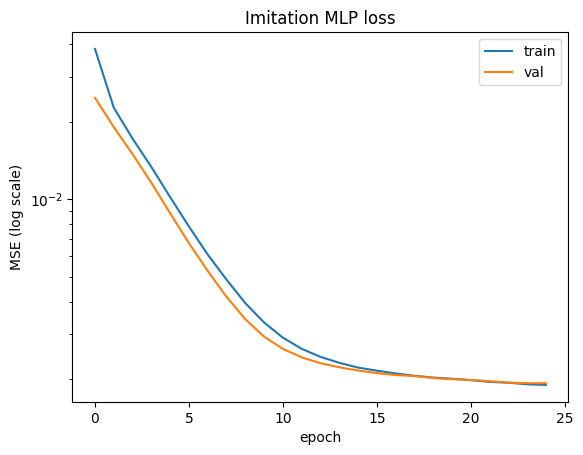

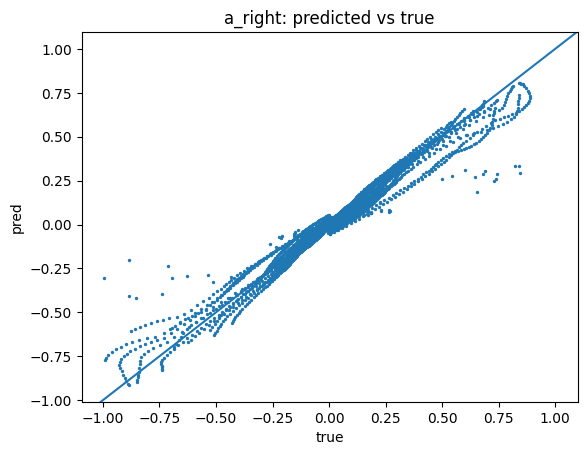

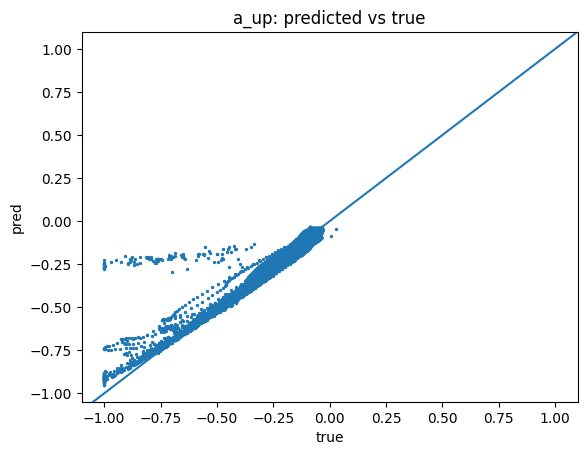

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ----------------------------
# 0) Checkpoint save/load utilities
# ----------------------------
def save_checkpoint(path, model, optim=None, extra=None):
    """Save model checkpoint with metadata."""
    ckpt = {
        "model_state_dict": model.state_dict(),
        "extra": extra or {},
    }
    if optim is not None:
        ckpt["optim_state_dict"] = optim.state_dict()
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(ckpt, path)
    print(f"Saved checkpoint -> {path}")

def load_checkpoint(path, device=None):
    """Load model checkpoint and rebuild model from saved hyperparams."""
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(path, map_location=device)
    extra = ckpt.get("extra", {})
    # Rebuild model from saved hyperparams (fallback to defaults)
    in_dim  = extra.get("in_dim", 16)
    hidden  = extra.get("hidden", 64)
    out_dim = extra.get("out_dim", 2)

    model = ImitationMLP(in_dim=in_dim, hidden=hidden, out_dim=out_dim).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    print(f"Loaded checkpoint <- {path}")
    return model, ckpt

# ----------------------------
# 1) Collect dataset from ProNav
# ----------------------------
def collect_pronav_dataset(
    env_class,
    seeds,
    max_steps_per_episode=4000,
    subsample=1,
):
    """
    Roll out ProNav and collect (obs, action) pairs.

    subsample=1 keeps every step
    subsample=5 keeps every 5th step (less correlated data)
    """
    X = []
    Y = []
    events = []

    for s in seeds:
        env = env_class()
        obs, _ = env.reset(seed=int(s))
        done = False
        t = 0

        while not done and t < max_steps_per_episode:
            # ProNav action (teacher)
            a = env.calculate_pronav().astype(np.float32)

            # Store current obs -> action
            if (t % subsample) == 0:
                X.append(obs.astype(np.float32))
                Y.append(a)

            obs, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            t += 1

        events.append(info.get("event", "unknown"))

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y, events


# ----------------------------
# 2) Simple MLP for imitation
# ----------------------------
class ImitationMLP(nn.Module):
    def __init__(self, in_dim=16, hidden=64, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x):
        return self.net(x)


# ----------------------------
# 3) Train / eval utilities
# ----------------------------
def train_imitation_mlp(
    X_train, Y_train,
    X_val, Y_val,
    epochs=20,
    batch_size=1024,
    lr=3e-4,
    weight_decay=1e-5,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    model = ImitationMLP(in_dim=X_train.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = {"train_mse": [], "val_mse": []}

    for ep in range(1, epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_losses.append(loss.item())

        train_mse = float(np.mean(train_losses))
        val_mse = float(np.mean(val_losses))
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)

        print(f"Epoch {ep:02d} | train MSE={train_mse:.6f} | val MSE={val_mse:.6f}")

    return model, history


def eval_metrics(model, X, Y, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        xb = torch.from_numpy(X).to(device)
        pred = model(xb).cpu().numpy()

    err = pred - Y
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))

    # R^2 per output dim
    r2 = []
    for j in range(Y.shape[1]):
        y = Y[:, j]
        yhat = pred[:, j]
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - np.mean(y))**2) + 1e-9
        r2.append(float(1.0 - ss_res/ss_tot))

    # "sign match" for action components (rough sanity)
    sign_match = float(np.mean(np.sign(pred) == np.sign(Y)))

    return {"mse": mse, "mae": mae, "r2": r2, "sign_match": sign_match, "pred": pred}


# ----------------------------
# 4) Run the test
# ----------------------------
# Split seeds so eval is truly held-out
train_seeds = list(range(0, 300))     # 300 episodes train
val_seeds   = list(range(300, 360))   # 60 episodes val
test_seeds  = list(range(360, 460))   # 100 episodes test

# Collect (obs, action)
Xtr, Ytr, ev_tr = collect_pronav_dataset(missile_interception_3d, train_seeds, subsample=3)
Xva, Yva, ev_va = collect_pronav_dataset(missile_interception_3d, val_seeds, subsample=3)
Xte, Yte, ev_te = collect_pronav_dataset(missile_interception_3d, test_seeds, subsample=3)

print("Dataset sizes:", Xtr.shape, Xva.shape, Xte.shape)

# Train
model, hist = train_imitation_mlp(Xtr, Ytr, Xva, Yva, epochs=25, batch_size=2048)

# Evaluate
m = eval_metrics(model, Xte, Yte)
print("\nTEST METRICS")
print("MSE:", m["mse"])
print("MAE:", m["mae"])
print("R2 (right, up):", m["r2"])
print("Sign match:", m["sign_match"])

# Plot learning curve
plt.figure()
plt.plot(hist["train_mse"], label="train")
plt.plot(hist["val_mse"], label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE (log scale)")
plt.legend()
plt.title("Imitation MLP loss")
plt.show()

# Scatter plots: predicted vs true
pred = m["pred"]
for j, name in enumerate(["a_right", "a_up"]):
    plt.figure()
    plt.scatter(Yte[:, j], pred[:, j], s=2)
    plt.xlabel("true")
    plt.ylabel("pred")
    plt.title(f"{name}: predicted vs true")
    plt.axline((0,0),(1,1))
    plt.show()





RIGHT: std=0.151030 var=2.281013e-02  MAE=0.017909  MSE=1.201028e-03  corr=0.9751
UP: std=0.184193 var=3.392704e-02  MAE=0.028003  MSE=3.292437e-03  corr=0.9505


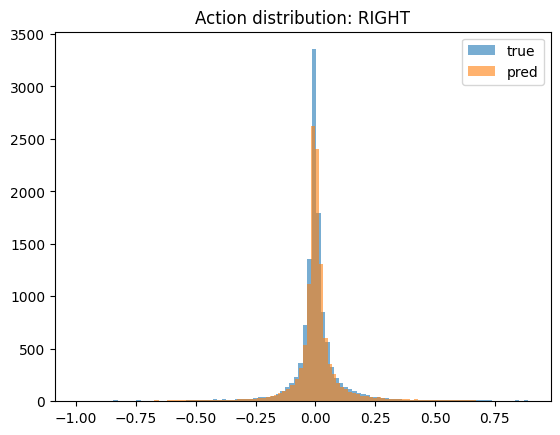

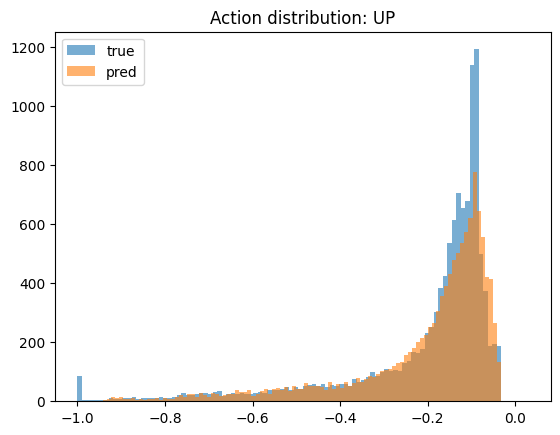

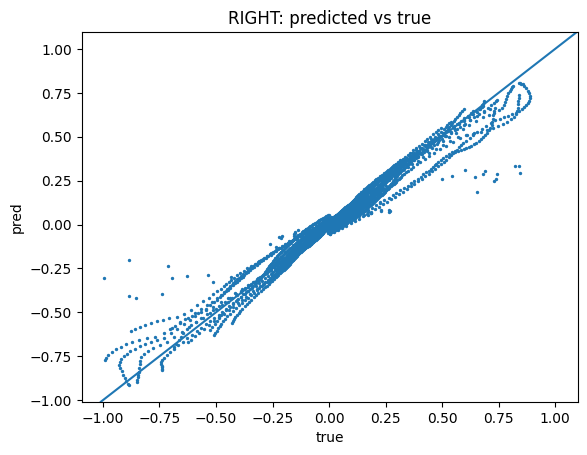

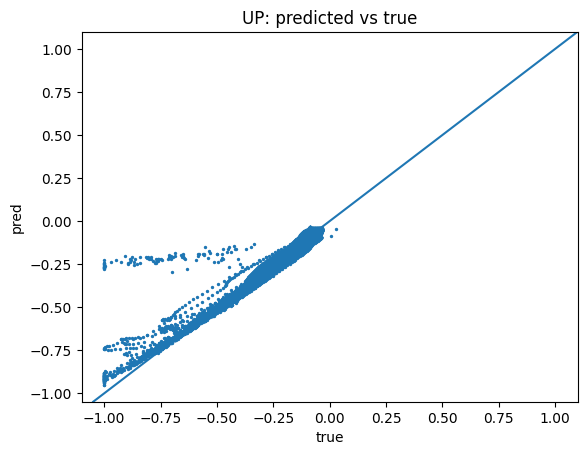

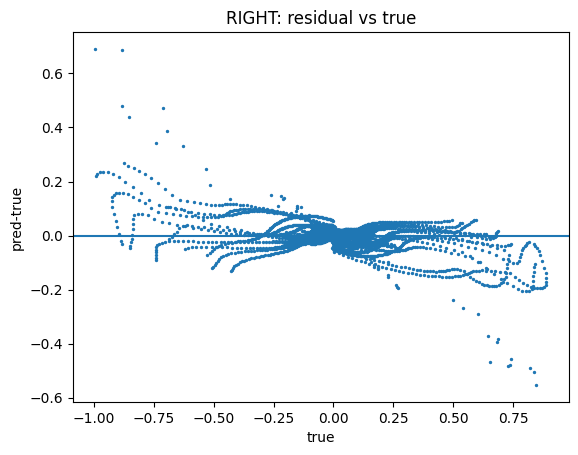

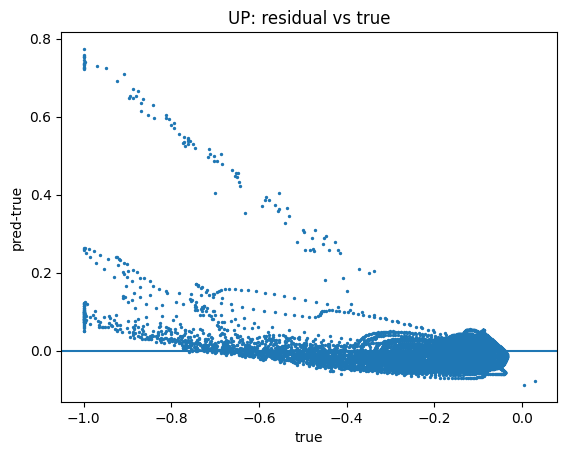

R2 RIGHT (all): 0.94734675
R2 RIGHT (|y|>0.05): 0.95306087 count 3776
R2 UP (all): 0.90295535
R2 UP (|y|>0.05): 0.90138835 count 11743


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Yte: true actions (N,2)
# pred: predicted actions (N,2)  (from your eval)
# If you didn't keep pred, re-run eval_metrics and grab m["pred"]

def quick_stats(y, yhat, name):
    err = yhat - y
    mse = np.mean(err**2)
    mae = np.mean(np.abs(err))
    var = np.var(y)
    std = np.std(y)
    corr = np.corrcoef(y, yhat)[0,1]
    print(f"{name}: std={std:.6f} var={var:.6e}  MAE={mae:.6f}  MSE={mse:.6e}  corr={corr:.4f}")

# 1) Basic variance check + correlation
quick_stats(Yte[:,0], pred[:,0], "RIGHT")
quick_stats(Yte[:,1], pred[:,1], "UP")

# 2) Histograms (are you mostly near 0?)
for j, nm in enumerate(["RIGHT", "UP"]):
    plt.figure()
    plt.hist(Yte[:,j], bins=100, alpha=0.6, label="true")
    plt.hist(pred[:,j], bins=100, alpha=0.6, label="pred")
    plt.title(f"Action distribution: {nm}")
    plt.legend()
    plt.show()

# 3) Pred vs True scatter (with diagonal)
for j, nm in enumerate(["RIGHT", "UP"]):
    plt.figure()
    plt.scatter(Yte[:,j], pred[:,j], s=2)
    plt.axline((0,0),(1,1))
    plt.title(f"{nm}: predicted vs true")
    plt.xlabel("true")
    plt.ylabel("pred")
    plt.show()

# 4) Residuals vs true (do errors blow up at extremes?)
for j, nm in enumerate(["RIGHT", "UP"]):
    plt.figure()
    plt.scatter(Yte[:,j], (pred[:,j]-Yte[:,j]), s=2)
    plt.axhline(0.0)
    plt.title(f"{nm}: residual vs true")
    plt.xlabel("true")
    plt.ylabel("pred-true")
    plt.show()

# 5) R² on “non-trivial” actions only (filters out near-zero noise)
threshold = 0.05  # try 0.02, 0.05, 0.1
mask_r = np.abs(Yte[:,0]) > threshold
mask_u = np.abs(Yte[:,1]) > threshold

def r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-9
    return 1.0 - ss_res/ss_tot

print("R2 RIGHT (all):", r2(Yte[:,0], pred[:,0]))
print(f"R2 RIGHT (|y|>{threshold}):", r2(Yte[mask_r,0], pred[mask_r,0]), "count", mask_r.sum())

print("R2 UP (all):", r2(Yte[:,1], pred[:,1]))
print(f"R2 UP (|y|>{threshold}):", r2(Yte[mask_u,1], pred[mask_u,1]), "count", mask_u.sum())


In [13]:
import numpy as np
import torch
from collections import Counter

# ----------------------------
# Helpers
# ----------------------------
def clamp01(x, lo=-1.0, hi=1.0):
    return np.clip(x, lo, hi).astype(np.float32)

def mlp_action_fn(model, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    @torch.no_grad()
    def _act(obs):
        # obs: (obs_dim,)
        x = torch.from_numpy(obs.astype(np.float32)).to(device)
        y = model(x).detach().cpu().numpy().astype(np.float32)
        return clamp01(y)
    return _act

def hybrid_action(a_student, a_teacher, k=0.5):
    # student + k*(teacher - student) = (1-k)*student + k*teacher
    return clamp01(a_student + k * (a_teacher - a_student))

# ----------------------------
# Core rollout with detailed logs
# ----------------------------
def rollout_with_metrics(env_class, seed, policy_mode, student_act=None, k=0.5, max_steps=10000):
    """
    policy_mode in {"teacher", "student", "hybrid"}
    student_act: callable(obs)->action in [-1,1]^2 (required for student/hybrid metrics)
    """
    env = env_class()
    obs, _ = env.reset(seed=int(seed))

    done = False
    steps = 0

    # Per-episode aggregates
    max_abs_comp = 0.0
    max_norm = 0.0
    large_wrong_sign_count = 0          # counts per-component events across time
    large_wrong_sign_any_count = 0      # counts timesteps where any component triggers

    # Weighted sign agreement (two variants)
    w1_total = 0.0
    w1_match = 0.0
    w2_total = 0.0
    w2_match = 0.0

    # Cosine similarity (unweighted + weighted by |teacher|)
    cos_sum = 0.0
    cos_n = 0
    cos_w_sum = 0.0
    cos_w_total = 0.0

    eps = 1e-9

    while not done and steps < max_steps:
        # Always compute teacher and student actions for metrics
        a_teacher = env.calculate_pronav().astype(np.float32)

        if student_act is None:
            a_student = np.zeros_like(a_teacher, dtype=np.float32)
        else:
            a_student = student_act(obs).astype(np.float32)

        # Choose executed action
        if policy_mode == "teacher":
            a_exec = a_teacher
        elif policy_mode == "student":
            a_exec = a_student
        elif policy_mode == "hybrid":
            a_exec = hybrid_action(a_student, a_teacher, k=k)
        else:
            raise ValueError(f"Unknown policy_mode={policy_mode}")

        # Saturation logs on executed action
        max_abs_comp = max(max_abs_comp, float(np.max(np.abs(a_exec))))
        max_norm = max(max_norm, float(np.linalg.norm(a_exec)))

        # Large wrong-sign events (teacher vs student), component-wise
        # Condition: (teacher*student < 0) AND |teacher| > 0.1
        wrong = (a_teacher * a_student < 0.0) & (np.abs(a_teacher) > 0.1)
        large_wrong_sign_count += int(np.sum(wrong))
        large_wrong_sign_any_count += int(np.any(wrong))

        # Weighted sign agreement (component-wise, then aggregated)
        # sign match: same sign including zeros; weight based on teacher magnitude
        sign_equal = (np.sign(a_teacher) == np.sign(a_student)).astype(np.float32)

        w1 = np.abs(a_teacher)                 # |teacher|
        w2 = w1 * w1                           # |teacher|^2

        w1_total += float(np.sum(w1))
        w1_match += float(np.sum(w1 * sign_equal))
        w2_total += float(np.sum(w2))
        w2_match += float(np.sum(w2 * sign_equal))

        # Cosine similarity between 2D vectors (direction agreement)
        nt = float(np.linalg.norm(a_teacher))
        ns = float(np.linalg.norm(a_student))
        if nt > 1e-6 and ns > 1e-6:
            cos = float(np.dot(a_teacher, a_student) / (nt * ns + eps))
            cos_sum += cos
            cos_n += 1

            # Weighted by |teacher| norm (ignore near-zero teacher commands)
            cos_w_sum += cos * nt
            cos_w_total += nt

        # Step env
        obs, r, terminated, truncated, info = env.step(a_exec)
        done = terminated or truncated
        steps += 1

    # Episode end stats
    event = info.get("event", "unknown")
    final_dist = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
    min_dist = float(getattr(env, "min_dist", final_dist))

    weighted_sign_1 = (w1_match / (w1_total + eps)) if w1_total > 0 else float("nan")
    weighted_sign_2 = (w2_match / (w2_total + eps)) if w2_total > 0 else float("nan")
    cos_mean = (cos_sum / max(cos_n, 1)) if cos_n > 0 else float("nan")
    cos_w_mean = (cos_w_sum / (cos_w_total + eps)) if cos_w_total > 0 else float("nan")

    return {
        "seed": int(seed),
        "policy": policy_mode,
        "event": event,
        "steps": steps,
        "min_dist": min_dist,
        "final_dist": final_dist,
        "max_abs_comp": max_abs_comp,
        "max_norm": max_norm,
        "large_wrong_sign_count": large_wrong_sign_count,
        "large_wrong_sign_any_count": large_wrong_sign_any_count,
        "weighted_sign_|t|": weighted_sign_1,
        "weighted_sign_|t|^2": weighted_sign_2,
        "cos_mean": cos_mean,
        "cos_w_mean": cos_w_mean,
    }

# ----------------------------
# Batch evaluation: Teacher vs Student vs Hybrid
# ----------------------------
def evaluate_three_policies(env_class, model, seeds, k=0.5, verbose_first_n=5):
    student_act = mlp_action_fn(model)

    results = {"teacher": [], "student": [], "hybrid": []}

    for i, s in enumerate(seeds):
        for mode in ["teacher", "student", "hybrid"]:
            out = rollout_with_metrics(
                env_class=env_class,
                seed=s,
                policy_mode=mode,
                student_act=student_act,
                k=k,
            )
            results[mode].append(out)

        if i < verbose_first_n:
            t = results["teacher"][-1]
            st = results["student"][-1]
            hb = results["hybrid"][-1]
            print(f"Seed {s:3d} | "
                  f"T:{t['event']:>12s} md={t['min_dist']:7.1f} | "
                  f"S:{st['event']:>12s} md={st['min_dist']:7.1f} | "
                  f"H:{hb['event']:>12s} md={hb['min_dist']:7.1f}")

    def summarize(mode_results):
        events = [r["event"] for r in mode_results]
        c = Counter(events)
        hit_rate = c.get("hit", 0) / len(mode_results)

        min_dists = np.array([r["min_dist"] for r in mode_results], dtype=np.float32)

        # Saturation
        max_abs = np.array([r["max_abs_comp"] for r in mode_results], dtype=np.float32)
        max_norm = np.array([r["max_norm"] for r in mode_results], dtype=np.float32)

        # Wrong-sign
        wsc = np.array([r["large_wrong_sign_count"] for r in mode_results], dtype=np.float32)
        wsa = np.array([r["large_wrong_sign_any_count"] for r in mode_results], dtype=np.float32)

        # Weighted sign + cos
        ws1 = np.array([r["weighted_sign_|t|"] for r in mode_results], dtype=np.float32)
        ws2 = np.array([r["weighted_sign_|t|^2"] for r in mode_results], dtype=np.float32)
        cosm = np.array([r["cos_mean"] for r in mode_results], dtype=np.float32)
        cosw = np.array([r["cos_w_mean"] for r in mode_results], dtype=np.float32)

        return {
            "hit_rate": hit_rate,
            "median_min_dist": float(np.median(min_dists)),
            "mean_min_dist": float(np.mean(min_dists)),
            "events": c,
            "max_abs_comp_mean": float(np.mean(max_abs)),
            "max_abs_comp_max": float(np.max(max_abs)),
            "max_norm_mean": float(np.mean(max_norm)),
            "max_norm_max": float(np.max(max_norm)),
            "large_wrong_sign_count_mean": float(np.mean(wsc)),
            "large_wrong_sign_count_max": float(np.max(wsc)),
            "large_wrong_sign_any_mean": float(np.mean(wsa)),
            "weighted_sign_|t|_mean": float(np.nanmean(ws1)),
            "weighted_sign_|t|^2_mean": float(np.nanmean(ws2)),
            "cos_mean": float(np.nanmean(cosm)),
            "cos_w_mean": float(np.nanmean(cosw)),
        }

    summary = {mode: summarize(results[mode]) for mode in results}

    # Pretty print summaries
    print("\n" + "="*70)
    print(f"FIXED-SEED EVAL (n={len(seeds)}) | Hybrid k={k}")
    print("="*70)
    for mode in ["teacher", "student", "hybrid"]:
        s = summary[mode]
        print(f"\n[{mode.upper()}]")
        print(f"Hit rate: {s['hit_rate']*100:6.2f}% | median min_dist={s['median_min_dist']:.1f} m | mean min_dist={s['mean_min_dist']:.1f} m")
        print(f"Events: {dict(s['events'])}")
        print(f"Max |action| (abs-comp) mean={s['max_abs_comp_mean']:.3f} max={s['max_abs_comp_max']:.3f}")
        print(f"Max |action| (L2-norm)  mean={s['max_norm_mean']:.3f} max={s['max_norm_max']:.3f}")
        print(f"Large wrong-sign count/ep mean={s['large_wrong_sign_count_mean']:.2f} max={s['large_wrong_sign_count_max']:.0f}")
        print(f"Large wrong-sign any-timestep/ep mean={s['large_wrong_sign_any_mean']:.2f}")
        print(f"Weighted sign agreement (|t|):   {s['weighted_sign_|t|_mean']:.4f}")
        print(f"Weighted sign agreement (|t|^2): {s['weighted_sign_|t|^2_mean']:.4f}")
        print(f"Cosine similarity mean:          {s['cos_mean']:.4f}")
        print(f"Cosine similarity weighted mean: {s['cos_w_mean']:.4f}")

    print("\n" + "="*70)

    return results, summary

# ----------------------------
# Run it (same fixed seeds you already use)
# ----------------------------
# EVAL_SEEDS = list(range(200))  # you already have this
results, summary = evaluate_three_policies(
    env_class=missile_interception_3d,
    model=model,
    seeds=EVAL_SEEDS,
    k=0.5,
    verbose_first_n=5
)


Seed   0 | T:         hit md=  133.0 | S:defense_ground md= 1525.8 | H:         hit md=  111.5
Seed   1 | T:         hit md=  112.4 | S:defense_ground md= 3902.8 | H:         hit md=  126.7
Seed   2 | T:         hit md=  113.3 | S:defense_ground md= 1509.3 | H:         hit md=  131.8
Seed   3 | T:         hit md=  145.6 | S:enemy_ground md=14646.8 | H:         hit md=  143.2
Seed   4 | T:         hit md=  141.9 | S:defense_ground md= 1964.2 | H:         hit md=  147.2

FIXED-SEED EVAL (n=200) | Hybrid k=0.5

[TEACHER]
Hit rate: 100.00% | median min_dist=133.1 m | mean min_dist=132.0 m
Events: {'hit': 200}
Max |action| (abs-comp) mean=0.740 max=1.000
Max |action| (L2-norm)  mean=0.788 max=1.242
Large wrong-sign count/ep mean=0.00 max=0
Large wrong-sign any-timestep/ep mean=0.00
Weighted sign agreement (|t|):   0.9934
Weighted sign agreement (|t|^2): 0.9996
Cosine similarity mean:          0.9909
Cosine similarity weighted mean: 0.9948

[STUDENT]
Hit rate:   0.00% | median min_dist=3943.